In [ ]:
!curl https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip     -O /tmp/cats_and_dogs_filtered.zip

In [50]:
import os # for using operating system dependent functionality
import zipfile # to unzip the files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img

In [34]:
pwd

'D:\\JupyterNotebook'

# Data Exploration

In [11]:
#unzip the files 
zip_file = 'D:\\JupyterNotebook\\cats_and_dogs_filtered.zip'
zip_file_ref = zipfile.ZipFile(zip_file , 'r') #To read the file 
zip_file_ref.extractall('D:\\JupyterNotebook\\') # To extract the files 
zip_file_ref.close() # To close the file

In [14]:
# Define the folder names of the data 
main_folder = 'D:\\JupyterNotebook\\cats_and_dogs_filtered\\'
train_folder = os.path.join(main_folder,'train')
train_cat_folder = os.path.join(train_folder,'cats')
train_dog_folder = os.path.join(train_folder,'dogs')
val_folder =  os.path.join(main_folder,'validation')
val_cat_folder =  os.path.join(val_folder,'cats')
val_dog_folder =  os.path.join(val_folder,'dogs')

In [17]:
# To verify the file names in cats folder
train_cat_filenm = os.listdir(train_cat_folder) # Lists the files
print(train_cat_filenm[:10])
train_dog_filenm = os.listdir(train_dog_folder) # Lists the files
print(train_dog_filenm[:10])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg', 'cat.102.jpg', 'cat.103.jpg', 'cat.104.jpg', 'cat.105.jpg', 'cat.106.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


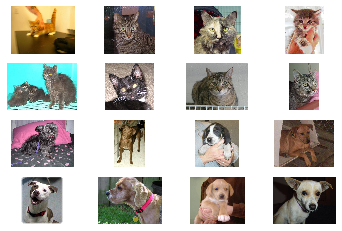

In [33]:
# We are plotting a 4*4 grid to display the cats and dogs pictures now 
nrows = 4 
ncol = 4
fig = plt.gcf() # To get the current figure 
fig.set_size_inches(nrows*4 , ncol*14) # Sets the grids in the mentioned sizes in inches


idx = 8
cat_pic = [os.path.join(train_cat_folder, filenm) for filenm in train_cat_filenm[idx-idx:idx]]
dog_pic = [os.path.join(train_dog_folder, filenm) for filenm in train_dog_filenm[idx-idx:idx]]

%matplotlib inline
for i, img_path in enumerate(cat_pic+dog_pic):
    sp = plt.subplot(nrows , ncol , i+1)
    sp.axis('Off') # Doesnt show the grid 
    img = mpimg.imread (img_path) # Converts image into an array of numeric values 
    plt.imshow(img)    # Plot the image of object


# Creation of model

In [39]:
img_ip = layers.Input(shape = (150,150,3)) # The input will take arrays of images with 150*150 in d dimention 

# when we transform the model from n dimension to 2*2, there will be loss of data 
# to prevent this, we use filters which retain the properties of the image while compressin it . 

x = layers.Conv2D(16, 3, activation='relu')(img_ip)
x = layers.MaxPooling2D(2)(x) #we are Maxpooling the image to 2*2 matrix image 

x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x) # Currently our moden is in 2D but the model accepts inputs in 1D only . So we platten our image 
x = layers.Dense(512, activation='relu')(x) # Create a fully connected layer with ReLU activation and 512 hidden units ##DOUBT

# Read this to understand backpropogation https://missinglink.ai/guides/neural-network-concepts/backpropagation-neural-networks-process-examples-code-minus-math/
output = layers.Dense(1, activation='sigmoid')(x) #https://missinglink.ai/guides/neural-network-concepts/7-types-neural-network-activation-functions-right/
model = Model(img_ip,output)

Check the summary of your model

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0     

In [42]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [46]:
# All images will be rescaled by 1./255
#Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches) 
# We can tilt the images
# Refer https://keras.io/preprocessing/image/
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen =  train_datagen.flow_from_directory(train_folder, target_size= (150, 150 ), batch_size = 20, class_mode='binary')
val_gen =  val_datagen.flow_from_directory(val_folder, target_size= (150, 150 ), batch_size = 20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [49]:
history = model.fit_generator(
      train_gen,
      steps_per_epoch = 100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data = val_gen,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/15
100/100 - 68s - loss: 0.8027 - acc: 0.5665 - val_loss: 0.6522 - val_acc: 0.6200
Epoch 2/15
100/100 - 43s - loss: 0.6568 - acc: 0.6675 - val_loss: 0.6065 - val_acc: 0.6860
Epoch 3/15
100/100 - 42s - loss: 0.5649 - acc: 0.7240 - val_loss: 0.5985 - val_acc: 0.7140
Epoch 4/15
100/100 - 42s - loss: 0.4957 - acc: 0.7650 - val_loss: 0.6094 - val_acc: 0.7140
Epoch 5/15
100/100 - 42s - loss: 0.3983 - acc: 0.8215 - val_loss: 0.5751 - val_acc: 0.7330
Epoch 6/15
100/100 - 42s - loss: 0.3288 - acc: 0.8540 - val_loss: 0.6570 - val_acc: 0.7260
Epoch 7/15
100/100 - 44s - loss: 0.2514 - acc: 0.8990 - val_loss: 0.6433 - val_acc: 0.7080
Epoch 8/15
100/100 - 43s - loss: 0.1608 - acc: 0.9410 - val_loss: 0.7267 - val_acc: 0.7190
Epoch 9/15
100/100 - 42s - loss: 0.1232 - acc: 0.9515 - val_loss: 1.0191 - val_acc: 0.7320
Epoch 10/15


The validation loss is increasing and the training data loss is decreasing . The data may be overfitting . #Doubts 

In [51]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


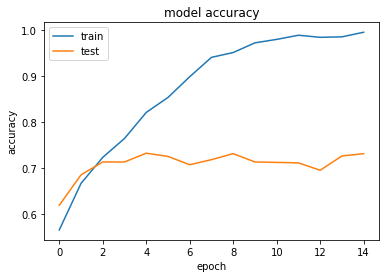

In [52]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

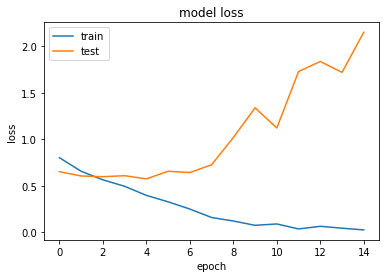

In [53]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()